# TP 4: Improve the Metropolis-Hastings algorithm

### Student : Simon Queric

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

### 1.A – Metropolis-Hastings within Gibbs sampler

#### Question 1

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
from scipy.stats import invgamma

In [5]:
a = 10
@jit(nopython=True)
def log_pi1(x, param) :
    y = param[0]
    a = param[1]
    return -x**2/a**2 - (x**2/a**2 - y**2)**2/4
@jit(nopython=True)
def log_pi2(y, param) :
    x = param[0]
    a = param[1]
    return -y**2 - (x**2/a**2 - y**2)**2/4

In [6]:
@jit(nopython=True)
def MH(x0, y0, a, n_iter=100, sigma1=3, sigma2=3) :
    X = np.zeros(n_iter)
    Y = np.zeros(n_iter)
    x = x0
    y = y0
    for i in range(n_iter) : 
        u = np.random.uniform(0, 1)
        if u <= 0.5 : 
            x_new = np.random.normal(x, sigma1)
            alpha = np.exp(min(0, log_pi1(x_new, (y, a)) - log_pi1(x, (y, a))))
            v = np.random.uniform(0, 1)
            if v <= alpha : 
                X[i]=x_new
                x = x_new
            else :
                X[i] = x
            Y[i] = y
        else : 
            y_new = np.random.normal(y, sigma2)
            alpha = np.exp(min(0, log_pi2(y_new, (x, a)) - log_pi2(y, (x, a))))
            v = np.random.uniform(0, 1)
            if v <= alpha : 
                Y[i]=y_new
                y = y_new
            else :
                Y[i] = y
            X[i] = x
            
    return X, Y

In [7]:
X, Y = MH(x0=1, y0=1, a=10, n_iter=2000, sigma1=3, sigma2=3)

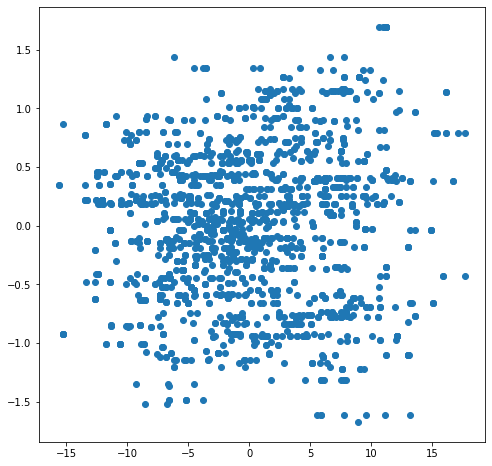

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(X, Y)
plt.show()

In [9]:
X = (X - X.mean())/X.std()
Y = (Y - Y.mean())/Y.std()

In [10]:
def auto_corr(x):
    corr = np.correlate(x, x, mode="full")
    n = len(x)
    return corr[n-1:]

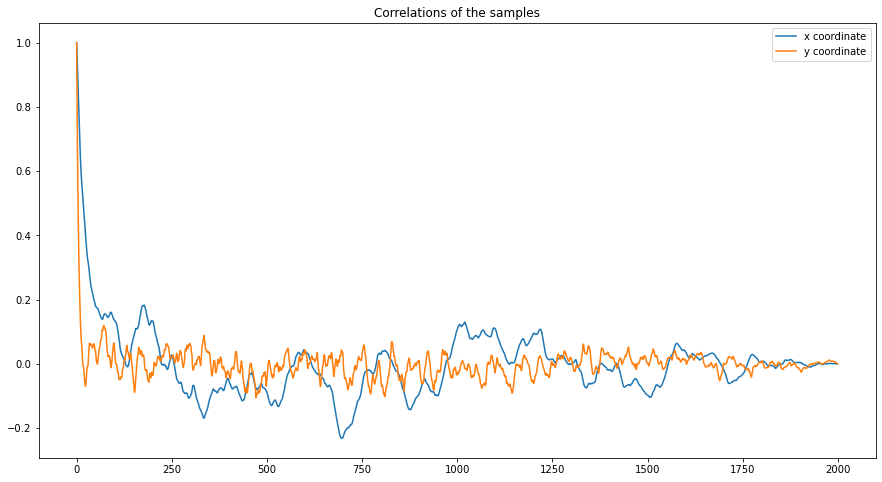

In [11]:
fig = plt.figure(figsize=(15, 8))
plt.plot(auto_corr(X)/len(X))
plt.plot(auto_corr(Y)/len(Y))
plt.title("Correlations of the samples")
plt.legend(["x coordinate", "y coordinate"])
plt.show()

3. Gibbs sampling random scan

In [12]:
@jit(nopython=True)
def MH_univariate(x0, log_pi, param, sigma_prop, n_iter):
    """
    Symmetric random walk Metropolis-Hasting algorithm for a real random variable 

    input
    -----
    x0 : initial point
    log_pi : log probability of the target density up to an additive constant
    param : parameters of the density
    n_iter : number of iteration of Metropolis-Hasting

    output
    ------
    x : last sample of MH
    alpha : last acceptance rate
    """
    x = x0
    for _ in range(n_iter) : 
        y = np.random.normal(x, sigma_prop) 
        alpha = np.exp(min(0, log_pi(y, param=param)-log_pi(x, param=param)))
        u = np.random.uniform(0, 1)
        if u<= alpha :
            x = y 
    return x, alpha

In [13]:
a = 10

In [14]:
log_pi1(1, (1, a))

-0.255025

In [15]:
def adaptative_MH_wG(x0, param, log_pis, sigmas, batch_size=50, hm_iter=100, n_iter=1000) :
    """ 
    Implementation of the adaptative Gibbs sampler

    input
    -----
    x0 : initial point
    param : parameters of distribution
    log_pis : list of conditional log-probabilities
    sigmas : list of proposal variances for each coordinates
    hm_iter : number of Hasting-Metropolis iterations
    n_iter : number of Gibbs iteration

    output
    ------
    X : Markov chain trajectory
    Alphas : acceptance ratio
    """
    d = x0.shape[0]
    print(d)
    x_k = np.copy(x0)
    X = np.zeros((n_iter, d))
    l = np.log(sigmas)
    j=0
    alphas = np.zeros(d)
    Alphas = np.zeros((n_iter//batch_size, d))
    for k in range(n_iter):
        for i in range(d) :
            y = x_k[i]
            z = np.concatenate((x_k[:i], x_k[i+1:]))
            if d==2:
                z=z[0]
            x, alpha = MH_univariate(x_k[i], log_pis[i], param=(z, param), sigma_prop=np.exp(l[i]), n_iter=hm_iter)
            #alpha = np.exp(min(0, log_pis[i](y, param=(z, a))-log_pis[i](x, param=(z, a))))
            
            x_k[i] = x
            X[k,i] = x_k[i]
            alphas[i] += alpha #np.exp(min(0,log_pis[i](x_k[i], param=(z, a)) - log_pis[i](y, param=(z, a))))   

            if k>0 and k%batch_size==0:
                Alphas[k//batch_size, i] = alphas[i]/batch_size
                
                j = k//batch_size
                delta_j = min(1e-2, 1/np.sqrt(j))
                
                if alphas[i]/batch_size < 0.24 :
                    l[i] -= delta_j
                    
                elif alphas[i]/batch_size > 0.24 : 
                    l[i] += delta_j
                    
                alphas[i] = Alphas[-1,i]

    return X, Alphas

In [16]:
x0 = np.ones(2)
n_iter=50_000
log_pis = [log_pi1, log_pi2]
X, Alphas = adaptative_MH_wG(x0, a, log_pis, sigmas=np.array([3, 3]), batch_size=50, hm_iter=100, n_iter=n_iter)

2


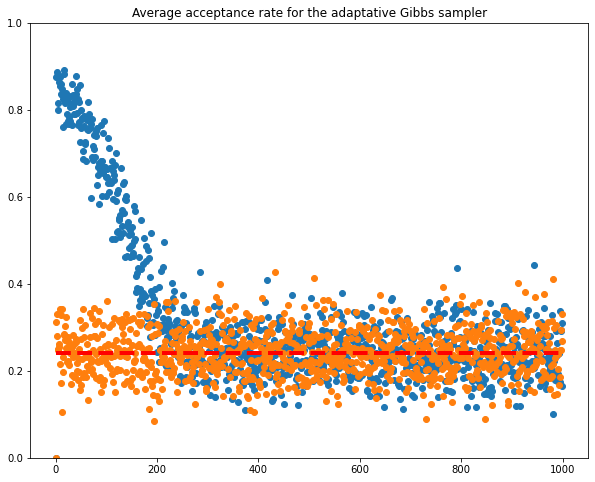

In [17]:
fig=plt.figure(figsize=(10, 8))
plt.plot(Alphas[:,0], 'o', lw=1)
plt.plot(Alphas[:,1], 'o', lw=1)
plt.hlines(0.24, 1, n_iter//50, "red", ls="--", lw=4)
plt.title("Average acceptance rate for the adaptative Gibbs sampler")
plt.ylim([0, 1])
plt.show()

In [18]:
X, Y = X[:,0], X[:,1]

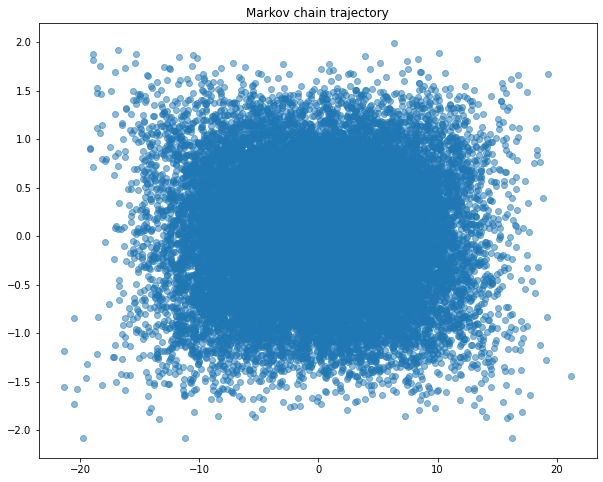

In [19]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(X[n_iter//2:], Y[n_iter//2:], alpha=.5)
plt.title("Markov chain trajectory")
plt.show()

In [20]:
X = (X - X.mean())/X.std()
Y = (Y - Y.mean())/Y.std()

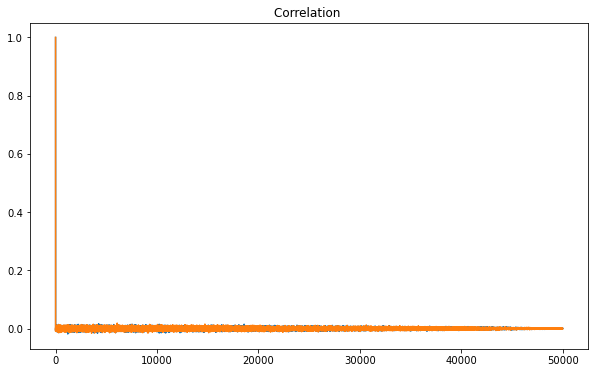

In [21]:
fig = plt.figure(figsize=(10, 6))
plt.plot(auto_corr(X)/len(X))
plt.plot(auto_corr(Y)/len(Y))
plt.title("Correlation ")
plt.show()

## Banana-shaped density

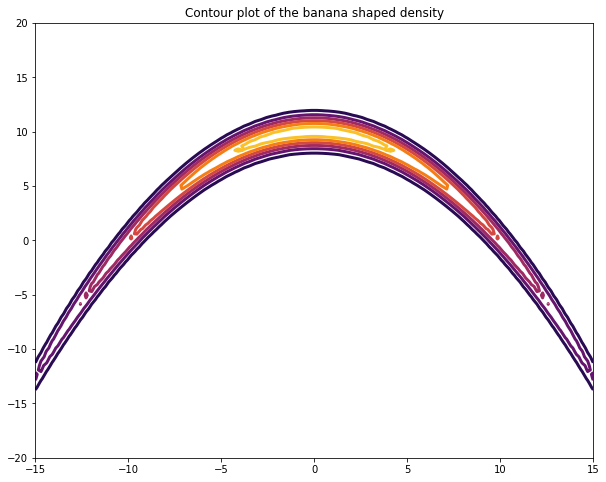

In [40]:
B = 0.1 
def f(x, y, B):  
    return np.exp(-x**2/200 - (y + B*x**2 - 100*B)**2/2)


fig = plt.figure(figsize=(10, 8))
x = np.linspace(-15, 15, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y, B)
plt.contour(X, Y, Z, cmap="inferno", linewidths=3)
plt.title("Contour plot of the banana shaped density")
plt.show()

In [22]:
a = 10
@jit(nopython=True)
def log_pi1(x, param) :
    y = param[0][0]
    B = param[1]
    return -x**2/200 - (y +B*x**2 - 100*B)**2/2
@jit(nopython=True)
def log_pi2(y, param) :
    x = param[0][0]
    B = param[1]
    return -(y +B*x**2 - 100*B)**2/2
@jit(nopython=True)
def log_pi_k(z, param):
    y = param[0][2:]
    return -(z**2+np.sum(y**2))/2

In [88]:
d = 20
x0 = np.zeros(d)
B = 0.1
n_iter=50_000
log_pis = [log_pi1, log_pi2] + [log_pi_k for _ in range(18)]

In [89]:
X, Alphas = adaptative_MH_wG(x0, B, log_pis, sigmas=3*np.ones(d), hm_iter=50, n_iter=n_iter)

20


In [ ]:
X, Y = X[:,0], X[:,1]

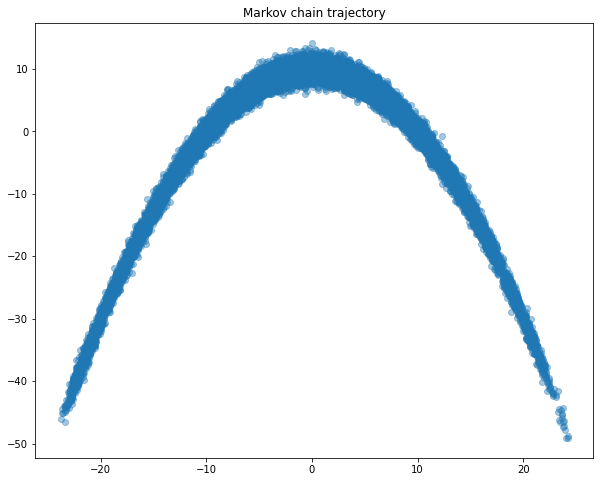

In [62]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(X[n_iter//2:], Y[n_iter//2:], alpha=.4)
x = np.linspace(-15, 15, 100)
y = np.linspace(-20, 20, 100)
x, y = np.meshgrid(x, y)
z = f(x, y, B)
#plt.contour(x, y, z, cmap='inferno', linewidths=3)
plt.title("Markov chain trajectory")
plt.show()

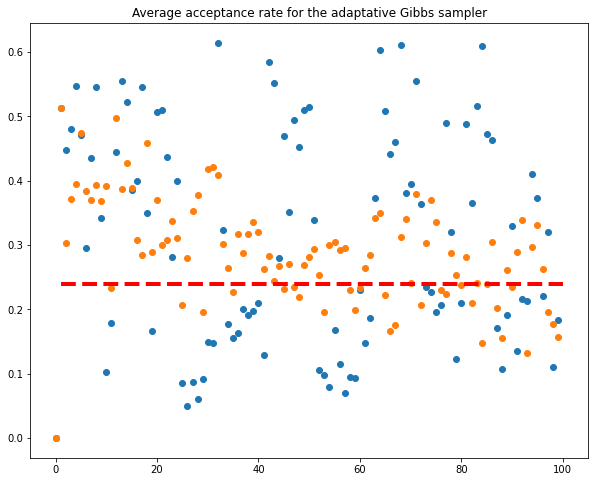

In [267]:
fig=plt.figure(figsize=(10, 8))
plt.plot(Alphas[:,0], 'o')
plt.plot(Alphas[:,1], 'o')
plt.hlines(0.24, 1, n_iter//50, "red", ls="--", lw=4)
plt.title("Average acceptance rate for the adaptative Gibbs sampler")
plt.show()

## Exercise 2 : Sampling from multimodal distributions

We want to sample from

\begin{equation*}
    \pi(x) = \sum_{i=1}^{20}{\frac{w_i}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2\sigma_i^2}\|x - \mu_i\|^2\right)}
\end{equation*}

In [25]:
d = 20
w = 0.05*np.ones(d)
sigma = 0.1*np.ones(d)
mu = np.array([[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82],
               [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40],
               [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50],
               [4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])

In [26]:
np.linalg.norm(mu - np.array([0, 0]), axis=1)

array([ 6.15873364, 12.92814759,  9.48092822,  8.57615881,  9.65594635,
        4.75430331,  1.77200451,  7.2407251 ,  9.02796766,  8.73824353,
        6.02416799,  8.32972989,  6.20406318,  2.64796148, 12.63482885,
        5.15314467,  1.83221178,  2.28116198,  8.81766409,  8.2842139 ])

In [27]:
@jit(nopython=True)
def logsumexp(x) :
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x-c)))

In [28]:
#@jit(nopython=True)
def log_pi(x, param) :
    mu = param[0]
    sigma = param[1]
    y = x - mu
    return logsumexp(-np.linalg.norm(y, axis=1)**2/(2*sigma**2))

In [29]:
def MH(x0, log_pi, param, sigma_prop=1e-2, n_iter=100):
    """
    Symmetric random walk Metropolis-Hasting algorithm for a multivariate random variable 

    input
    -----
    x0 : initial point
    log_pi : log probability of the target density up to an additive constant
    param : parameters of the density
    sigma_prop : variance of the proposal kernel 
    n_iter : number of iteration of Metropolis-Hasting

    output
    ------
    X : samples of Metropolis-Hasting
    """
    x = np.copy(x0)
    d = x.shape[0]
    X = np.zeros((n_iter, d))
    for k in range(n_iter) : 
        y = np.random.multivariate_normal(mean=x, cov=sigma_prop**2 *np.eye(d))
        alpha = np.exp(min(0, log_pi(y, param=param)-log_pi(x, param=param)))
        u = np.random.uniform(0, 1)
        if u<= alpha :
            x = y 

        X[k] = x
    return X

In [30]:
x0 = np.array([1.70, 0.50])
sigma = 0.1
param = (mu, sigma)
n_iter = 1000


In [31]:
X = MH(x0, log_pi, param, sigma_prop=1, n_iter=n_iter)

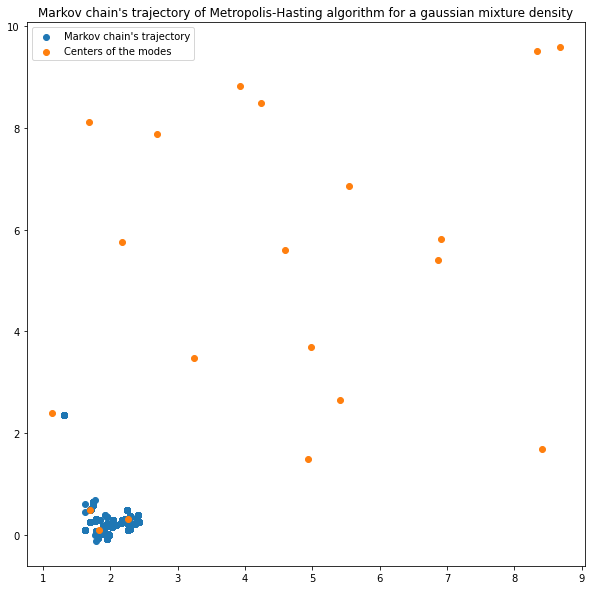

In [32]:
fig=plt.figure(figsize=(10, 10))
plt.scatter(X[:,0], X[:,1])
plt.scatter(mu[:,0], mu[:,1])
plt.legend(["Markov chain's trajectory", "Centers of the modes"])
plt.title("Markov chain's trajectory of Metropolis-Hasting algorithm for a gaussian mixture density")
plt.show()

We can see that the classical Symmetric Random Walk MH algorithm fails to sample from the distribution $\pi$. Indeed, the chain visits only between three and 5 modes over twenty.
This is due to the fact that the Markov chain makes small step and therefore doesn't visit all space states. 

## 2.B – Parallel Tempering

In [ ]:
def parallel_tempering():
    return 

## Exercise 3 : Bayesian analysis of a one-way random effects model

$\alpha, \beta, \gamma :$ known hyperparameters.

In [60]:
def gen_data(N, K, alpha, beta, gamma, mu) :
    sigma2 = invgamma.rvs(a=alpha, scale=beta)
    tau2 = invgamma.rvs(a=gamma, scale=beta)
    X = np.random.normal(mu,  np.sqrt(sigma2), size=N)
    eps = np.random.normal(0, np.sqrt(tau2), size=(N, K))
    y = np.zeros_like(eps)

    for i in range(N):
        y[i] = X[i] + eps[i]

    return y, X, mu, sigma2, tau2

In [61]:
# hyperparameters
N = 40
K = 10
alpha = 3
beta = 2
gamma = 2
mu = 2

In [62]:
y, X, mu, sigma2, tau2 = gen_data(N, K, alpha, beta, gamma, mu)

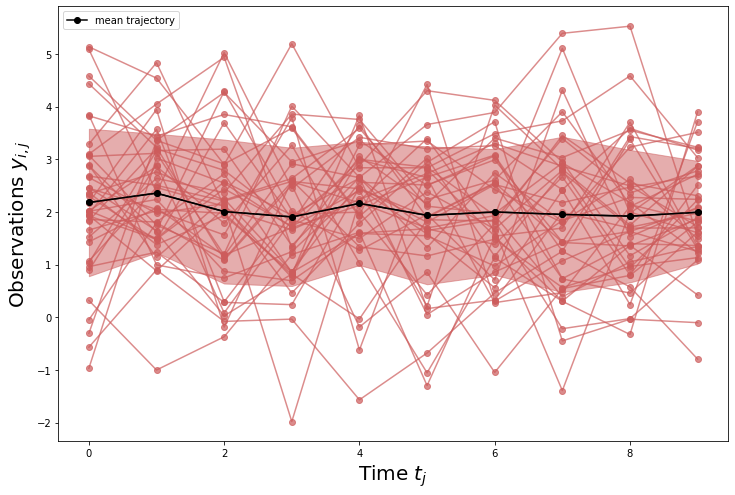

In [63]:
fig = plt.figure(figsize=(12, 8))
y_mean = y.mean(axis=0)
y_std = y.std(axis=0)
plt.plot(y_mean, "k", marker='o')
for n in range(N) :
    plt.plot(y[n,:], alpha=0.7, color="indianred", ls='-', marker='o')
plt.plot(y_mean, "k", marker='o')
plt.fill_between(list(range(K)), y_mean-y_std, y_mean+y_std, alpha=0.5, color="indianred")
plt.legend(["mean trajectory"])
plt.xlabel("Time $t_j$", fontsize=20)
plt.ylabel("Observations $y_{i, j}$", fontsize=20)
plt.show()

The density of the posterior distribution of $(X, \mu, \sigma^2, \tau^2)$ writes : 

\begin{equation*}
    \pi(X, \mu, \sigma^2, \tau^2 \mid y) \propto \frac{1}{\sigma^{2(1+\alpha) + N}}\exp\left(\frac{-\beta - \sum_{i=1}^N{(X_i-\mu)^2}}{\sigma^2}\right)\frac{1}{\tau^{2(1+\gamma) + NK}} \exp\left(-\frac{-\beta - \sum_{i,j}{(y_{i,j}-X_i)^2}}{\tau^2}\right)
\end{equation*}

Hence, we have the following conditional distributions :

\begin{equation*}
    \begin{aligned}
    \mathcal{L}(\sigma^2 \mid y, X, \mu, \tau^2) &= \text{Inverse-Gamma}(N+2\alpha+1, \beta) \\
    \mathcal{L}(\tau^2 \mid y, X, \mu, \sigma^2) &= \text{Inverse-Gamma}(KN+2\gamma+1, \beta) \\
     \mathcal{L}(X_i \mid y, \mu, \sigma^2, \tau^2) &= \mathcal{N}\left(\left(\frac{1}{\sigma^2}+\frac{1}{\tau^2}\right)^{-1} \left(\frac{\mu}{\sigma^2} + \frac{1}{K\tau^2}\sum_{j=1}^K{y_{i,j}}\right) , \left(\frac{2}{\sigma^2}+\frac{2}{\tau^2}\right)^{-1}\right) \\
     \mathcal{L}(\mu \mid y, X, \mu, \sigma^2) &= \mathcal{N}(\overline{X}, \sigma^2/2)
    \end{aligned}

\end{equation*}


In [67]:
def MH_wG(z0, y, n_iter=50) :
    z = np.copy(z0)
    N = len(z)
    X = z[:-3]
    mu = z[-3]
    sigma2 = z[-2]
    tau2 = z[-1]
    Z = np.zeros((n_iter, N))
    for i in range(n_iter) :
        sigma2 = invgamma.rvs(a=N/2+alpha, scale=beta)
        Z[i,-2] = sigma2
        tau2 = invgamma.rvs(a=N*K/2+gamma, scale=beta)
        Z[i,-1] = tau2 
        mu = np.random.normal(np.mean(X), np.sqrt(sigma2/2))
        Z[i,-3] = mu
        X = np.random.multivariate_normal(mean=(y.mean(axis=1)/tau2 + mu/sigma2)/(1/tau2 + 1/sigma2), 
                                   cov=1/(2/tau2 + 2/sigma2)*np.eye(N-3))
        Z[i,:-3] = X
        
    return Z

In [72]:
z_true = np.zeros(N+3)
z_true[:-3] = np.copy(X)
z_true[-3] = mu
z_true[-2] = sigma2
z_true[-1] = tau2
Z = MH_wG(z_true, y, n_iter=100)

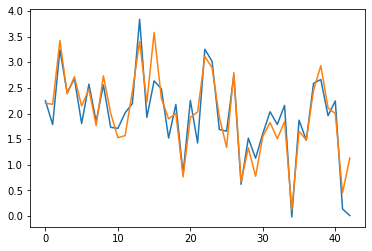

In [73]:
plt.plot(Z[-1])
plt.plot(z_true)
plt.show()

In [83]:
z0 = np.zeros(N+3)
z0[:-3] = -500
z0[-2] = 1e10
z0[-1] = 1e10
Z = MH_wG(z0, y, n_iter=100)

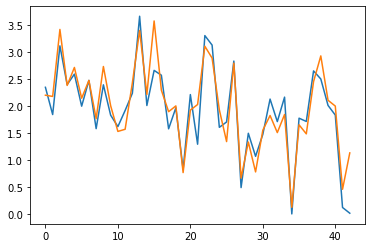

In [87]:
plt.plot(Z[-1])
plt.plot(z_true)
plt.show()

In [286]:
def block_MH_wG(z0, y, sigma_prop=1e-1, n_iter=50, hm_iter=100) :
    z = np.copy(z0)
    N = len(z)
    Xmu = z[:-2]
    sigma2 = z[-2]
    tau2 = z[-1]
    Z = np.zeros((n_iter, N))
    for i in range(n_iter) :
        sigma2, _ = MH_univariate(sigma2, log_pi_sigma2, param=(y, X, mu), sigma_prop=sigma_prop, n_iter=hm_iter)
        Z[i, -2] = sigma2
        tau2, _ = MH_univariate(tau2, log_pi_tau2, param=(y, X, mu), sigma_prop=sigma_prop, n_iter=hm_iter)
        Z[i, -1] = sigma2
        Xmu = MH(Xmu, log_pi_X_mu, param=(y, sigma2, tau2), sigma_prop=sigma_prop, n_iter=hm_iter)[-1]
        Z[i, :-2] = Xmu
        
    return Z

In [287]:
z_true = np.zeros(N+3)
z_true[:-3] = np.copy(X)
z_true[-3] = mu
z_true[-2] = sigma2
z_true[-1] = tau2

In [288]:
Z = block_MH_wG(z0, y, sigma_prop=1e-2/2, n_iter=100, hm_iter=100)

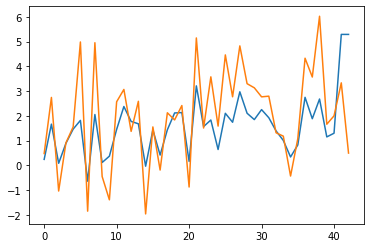

In [289]:
plt.plot(Z[-1])
plt.plot(z_true)
plt.show()

In [290]:
z0 = np.zeros(N+3)
z0[:-3] = 1
z0[-2] = 1
z0[-1] = 0.5

Z = block_MH_wG(z0, y, sigma_prop=1e-2/2, n_iter=100, hm_iter=100)

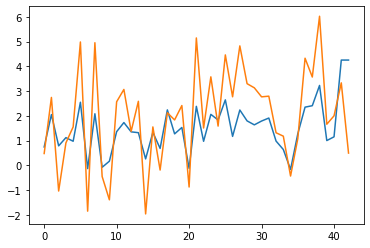

In [291]:
plt.plot(Z[-1])
plt.plot(z_true)
plt.show()

Very sensitive to $\sigma_{prop}$